In [1]:
from google.colab import drive

drive.mount("/content/drive/")

Mounted at /content/drive/


# Импорты

In [2]:
import collections
import datetime
import hashlib
import os
from base64 import b64encode

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
import statsmodels
import statsmodels.sandbox.stats.multicomp
from scipy.stats import norm
from sklearn.utils import shuffle
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm

In [3]:
pd.set_option("display.max_colwidth", -1)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 20000)

<ipython-input-3-57f4fc94f2aa>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Необходимые функции

In [4]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode

    salt = os.urandom(8)

    return b64encode(salt).decode("ascii")


def groups_splitter(df, columns, user_salt=None):
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df["hash"] = ((df["user_id"].astype(str)) + "#" + salt).apply(
        lambda x: hashlib.sha256(x.encode("utf-8")).hexdigest()
    )

    df["group"] = (df["hash"].str.slice(start=-6).apply(int, base=16) % 2).map(
        lambda x: "A" if x == 0 else "B"
    )

    return df[columns].drop_duplicates()


def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result


def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue


def get_mde(metric_vec, alpha=0.05, beta=0.2):
    metric_mean, metric_std, metric_n = (
        metric_vec.mean(),
        metric_vec.std(),
        metric_vec.count(),
    )

    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)

    mde = (z_alpha + z_beta) * metric_std / np.sqrt(metric_n)

    return mde * 100 / metric_mean

# Получение и предобработка данных

In [5]:
interactions = pd.read_csv(
    "/content/drive/MyDrive/itmo_recsys/kion_dataset/interactions.csv"
)

In [6]:
interactions["last_watch_dt"] = pd.to_datetime(interactions["last_watch_dt"]).map(
    lambda x: x.date()
)
interactions["user_id"] = interactions["user_id"].astype(str)

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


In [7]:
max_date = interactions["last_watch_dt"].max()
min_date = interactions["last_watch_dt"].min()
print(min_date, max_date)

2021-03-13 2021-08-22


In [8]:
week2 = interactions[
    interactions["last_watch_dt"] >= max_date - datetime.timedelta(days=14)
]
week2 = week2.groupby("user_id", as_index=False).agg({"total_dur": sum})

# Дизайн теста

## Корректность и мощность

Посчитаем корректность на бутстрапе, тем самым определим ошибку первого рода

In [ ]:
def calculate_correctness(df, columns, effect=None):
    correctness = []
    values = []
    for i in tqdm(range(1000)):
        new_df = groups_splitter(
            df.copy(), columns=columns, user_salt=salt_generator()
        ).drop_duplicates()
        vec_a = new_df[(new_df["group"] == "A")]["total_dur"]
        if effect:
            vec_b = new_df[(new_df["group"] == "B")]["total_dur"] * effect
        else:
            vec_b = new_df[(new_df["group"] == "B")]["total_dur"]
        sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
        sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
        values.append(sample_a_mean - sample_b_mean)
        left_side, right_side = np.percentile(
            sample_a_mean - sample_b_mean, [100 * 0.05 / 2.0, 100 * (1 - 0.05 / 2.0)]
        )
        correctness.append(not left_side <= 0 <= right_side)

    return correctness, values

In [ ]:
correctness, values = calculate_correctness(
    df=week2, columns=["user_id", "total_dur", "group"]
)

100%|██████████| 1000/1000 [2:46:52<00:00, 10.01s/it]


Сохраним данные

In [ ]:
correctness_pd = pd.DataFrame(correctness)
values_pd = pd.DataFrame(values)  # по строкам

In [ ]:
correctness_pd.to_csv("correctness_pd.csv", index=False)
values_pd.to_csv("values_pd.csv", index=False, sep=";")

In [ ]:
!cp correctness_pd.csv /content/drive/MyDrive/itmo_ab/hw-1

In [ ]:
!cp values_pd.csv /content/drive/MyDrive/itmo_ab/hw-1

Посчитаем мощность и так же сохраним данные

In [ ]:
EFFECTS = [1.01, 1.03, 1.05]

In [ ]:
for effect in EFFECTS:
    correctness, values = calculate_correctness(
        df=week2, columns=["user_id", "total_dur", "group"], effect=effect
    )
    correctness_pd = pd.DataFrame(correctness)
    values_pd = pd.DataFrame(values)
    correctness_pd.to_csv(f"correctness_pd_{int(effect*100)}.csv", index=False)
    values_pd.to_csv(f"values_pd_{int(effect*100)}.csv", index=False, sep=";")

100%|██████████| 1000/1000 [2:41:49<00:00,  9.71s/it]


In [ ]:
!cp correctness_pd_101.csv /content/drive/MyDrive/itmo_ab/hw-1
!cp correctness_pd_103.csv /content/drive/MyDrive/itmo_ab/hw-1
!cp correctness_pd_105.csv /content/drive/MyDrive/itmo_ab/hw-1
!cp values_pd_101.csv /content/drive/MyDrive/itmo_ab/hw-1
!cp values_pd_103.csv /content/drive/MyDrive/itmo_ab/hw-1
!cp values_pd_105.csv /content/drive/MyDrive/itmo_ab/hw-1

Проведем анализ полученных значений и построим график p-value (оценим на равномерность)

In [ ]:
correctness = pd.read_csv("/content/drive/MyDrive/itmo_ab/hw-1/correctness_pd.csv")
correctness_101 = pd.read_csv(
    "/content/drive/MyDrive/itmo_ab/hw-1/correctness_pd_101.csv"
)
correctness_103 = pd.read_csv(
    "/content/drive/MyDrive/itmo_ab/hw-1/correctness_pd_103.csv"
)
correctness_105 = pd.read_csv(
    "/content/drive/MyDrive/itmo_ab/hw-1/correctness_pd_105.csv"
)

values = pd.read_csv("/content/drive/MyDrive/itmo_ab/hw-1/values_pd.csv", sep=";")
values_101 = pd.read_csv(
    "/content/drive/MyDrive/itmo_ab/hw-1/values_pd_101.csv", sep=";"
)
values_103 = pd.read_csv(
    "/content/drive/MyDrive/itmo_ab/hw-1/values_pd_103.csv", sep=";"
)
values_105 = pd.read_csv(
    "/content/drive/MyDrive/itmo_ab/hw-1/values_pd_105.csv", sep=";"
)

* Считаем процент пар, в которых p-value ≤ 𝛼: т.е считаем в скольких случаях
критерий (сработал) нашел различия, когда его на самом деле нет.
* В нашем случае, считаем процент НЕ покрытия нуля

In [ ]:
correctness.astype(int).mean()

0    0.049
dtype: float64

Получилось 0.049. Близко к пяти процентам. Следовательно, вероятность отклонить нулевую гипотезу, когда она верна - 5%

In [ ]:
p_values = [get_p_value(values.iloc[i, :].tolist()) for i in range(1000)]

Text(0.5, 1.0, 'Бутстреп распределение p_value')

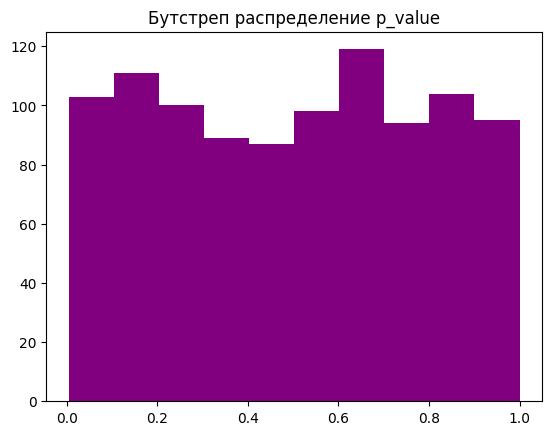

In [ ]:
plt.hist(p_values, bins=10, color="purple")
plt.title(f"Бутстреп распределение p_value")

In [ ]:
stat, p_value = scipy.stats.kstest(
    p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf
)

if p_value < 0.05:
    print(f"p_value = {p_value} - p_values неравномерное распределение")
else:
    print(f"p_value = {p_value} - p_values равномерное распределение")

p_value = 0.7097553870119024 - p_values равномерное распределение


Проделаем такое же упражнение для различных эффектов в группу B. И сравним мощность в разрезе

In [ ]:
correctness_101.astype(int).mean()

0    0.107
dtype: float64

In [ ]:
correctness_103.astype(int).mean()

0    0.625
dtype: float64

In [ ]:
correctness_105.astype(int).mean()

0    0.969
dtype: float64

* Вероятность отклонить нулевую гипотезу, когда нулевая гипотеза ложна =>
вероятность не допустить ошибку 2 рода (1 - β)
* Видим, что при добавлении эффекта в 5% в группу B, мы почти никогда не покрываем ноль. Это говорит о том, что с вероятностью 0.969 мы принимаем верное решение относительно гипотез
* Также хочу заметить, что наблюдается нелинейный рост правильных решений: при эффекте 1% - вероятность равна 0.107, а при 3% - уже 0.625


Text(0.5, 1.0, 'Бутстреп распределение p_value')

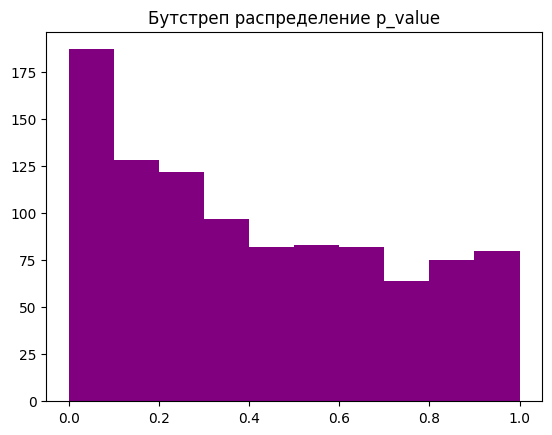

In [ ]:
p_values = [get_p_value(values_101.iloc[i, :].tolist()) for i in range(1000)]

plt.hist(p_values, bins=10, color="purple")
plt.title(f"Бутстреп распределение p_value")

Text(0.5, 1.0, 'Бутстреп распределение p_value')

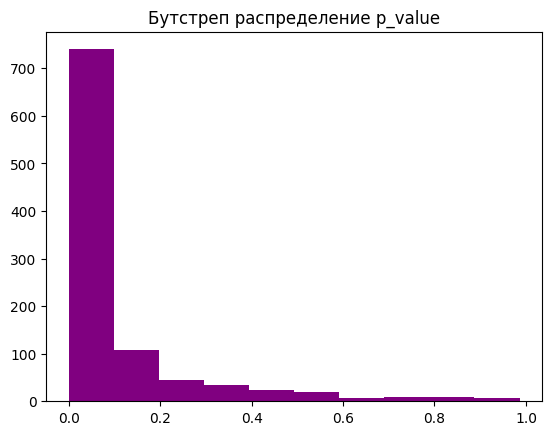

In [ ]:
p_values = [get_p_value(values_103.iloc[i, :].tolist()) for i in range(1000)]

plt.hist(p_values, bins=10, color="purple")
plt.title(f"Бутстреп распределение p_value")

Text(0.5, 1.0, 'Бутстреп распределение p_value')

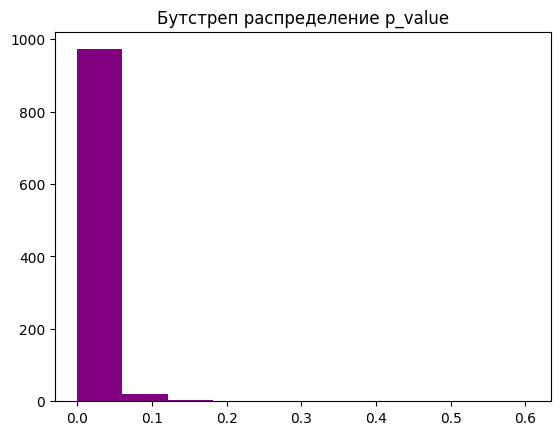

In [ ]:
p_values = [get_p_value(values_105.iloc[i, :].tolist()) for i in range(1000)]

plt.hist(p_values, bins=10, color="purple")
plt.title(f"Бутстреп распределение p_value")

С помощью графиков p-values мы можем подтвердить мою гипотезу о нелинейном росте

## MDE

* Для расчета MDE следует учесть, что формула с лекции работает для t-test и z-test. Однако я сделаю допущение, что для бутстрэпа в среднем будет так же (на семинаре об этом затрагивалось). В будущем изучу дополнительную литературу для MDE конкретно для бутстрэпа
* Подставлю свои значения alpha и beta (для 1%)

In [ ]:
get_mde(week2["total_dur"], alpha=0.049, beta=0.107)

2.068494941034016

Получился минимальный эффект в 2%. Это говорит о том, что мы можем обнаружить изменения в 2% с уверенностью в 1 - 0.049

# A/B тест

Занулим total_dur у тех пользователей, у которых total_dur < 500

In [9]:
week2["total_dur_prep"] = week2["total_dur"].apply(lambda x: 0 if x < 500 else x)

Разобьем данные с солью kiontestmodel20210805

In [10]:
new_df = groups_splitter(
    week2.copy(),
    columns=["user_id", "total_dur_prep", "group"],
    user_salt=salt_generator(salt="kiontestmodel20210805"),
).drop_duplicates()

In [11]:
new_df["group"].value_counts(normalize=True)

A    0.500389
B    0.499611
Name: group, dtype: float64

Увеличим total_dur на 2.5% у тех пользователей в группе B, которые входят в топ 10% самых смотрящих

In [12]:
new_df[new_df["group"] == "B"].shape

(139456, 3)

In [13]:
139802 * 0.1

13980.2

In [14]:
list_users = (
    new_df[new_df["group"] == "B"]
    .sort_values(by="total_dur_prep", ascending=False)
    .head(13980)["user_id"]
    .tolist()
)

In [15]:
new_df["total_dur_prep_final"] = new_df[["user_id", "total_dur_prep"]].apply(
    lambda x: x.total_dur_prep * 1.025 if x.user_id in list_users else x.total_dur_prep,
    axis=1,
)

In [16]:
def calculate_ab(df):
    correctness = []
    values = []
    for i in tqdm(range(1000)):
        vec_a = df[(df["group"] == "A")]["total_dur_prep_final"]
        vec_b = df[(df["group"] == "B")]["total_dur_prep_final"]
        sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
        sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
        values.append(sample_a_mean - sample_b_mean)
        left_side, right_side = np.percentile(
            sample_a_mean - sample_b_mean, [100 * 0.05 / 2.0, 100 * (1 - 0.05 / 2.0)]
        )
        correctness.append(not left_side <= 0 <= right_side)

    return correctness, values

In [ ]:
correctness, values = calculate_ab(new_df[["group", "total_dur_prep_final"]])

100%|██████████| 1000/1000 [2:16:31<00:00,  8.19s/it]


In [ ]:
correctness_pd = pd.DataFrame(correctness)
values_pd = pd.DataFrame(values)

In [ ]:
correctness_pd.to_csv("correctness_pd_ab.csv", index=False)
values_pd.to_csv("values_pd_ab.csv", index=False, sep=";")

In [ ]:
!cp correctness_pd_ab.csv /content/drive/MyDrive/itmo_ab/hw-1
!cp values_pd_ab.csv /content/drive/MyDrive/itmo_ab/hw-1

In [21]:
correctness_ab = pd.read_csv(
    "/content/drive/MyDrive/itmo_ab/hw-1/correctness_pd_ab.csv"
)
values_ab = pd.read_csv("/content/drive/MyDrive/itmo_ab/hw-1/values_pd_ab.csv", sep=";")

In [19]:
correctness_ab.astype(int).sum()

0    0
dtype: int64

Text(0.5, 1.0, 'Бутстреп распределение p_value')

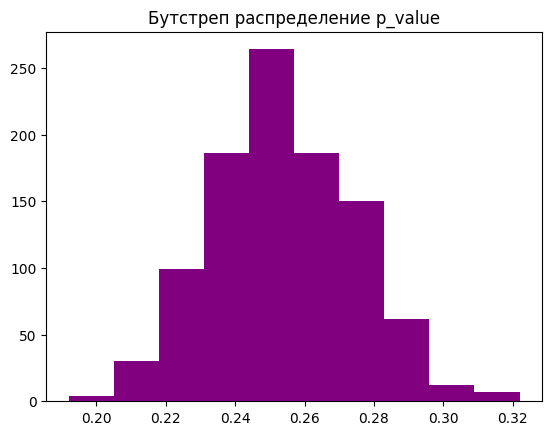

In [25]:
p_values = [get_p_value(values_ab.iloc[i, :].tolist()) for i in range(1000)]

plt.hist(p_values, bins=10, color="purple")
plt.title(f"Бутстреп распределение p_value")

* Можно увидеть, что ни одни границы из 1000 сэмплов не включали в себя ноль. Это может говорить о статистически значимом улучшении в тестовой группе по сравнению с контрольной
* Также p-values были меньше alpha = 0.049